In [ ]:
# Instalar as dependências necessárias
!pip install --quiet ultralytics opencv-python-headless

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.8/823.8 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 57.1 MB/s eta 0:00:00


In [ ]:
# Importar bibliotecas necessárias
import cv2
import numpy as np
import os
import sys
import contextlib
import time
import torch
import matplotlib.pyplot as plt
from ultralytics import YOLO
from IPython.display import clear_output, HTML

In [ ]:
# Carregar o modelo YOLOv5 pré-treinado
model = YOLO('yolov5su.pt')

In [ ]:
def detect_objects(frame):
    original_height, original_width = frame.shape[:2]
    # Redimensionar a imagem para o tamanho esperado pelo modelo
    resized_frame = cv2.resize(frame, (640, 640))
    # Converter para tensor
    tensor_frame = torch.from_numpy(resized_frame).permute(2, 0, 1).unsqueeze(0).float() / 255.0
    # Realizar inferência
    results = model(tensor_frame)
    # Manter os resultados na CPU
    boxes = results[0].boxes.xyxy
    confidences = results[0].boxes.conf
    class_ids = results[0].boxes.cls
    # Escalar as caixas de volta para o tamanho original da imagem
    boxes = scale_boxes(boxes, 640, 640, original_width, original_height)
    return boxes, confidences, class_ids

# Escala as caixas delimitadoras de uma imagem redimensionada de volta ao seu tamanho original
def scale_boxes(boxes, src_width, src_height, dst_width, dst_height):
    boxes = boxes.clone()  # Criar um clone do tensor antes de modificar
    boxes[:, 0] *= dst_width / src_width
    boxes[:, 1] *= dst_height / src_height
    boxes[:, 2] *= dst_width / src_width
    boxes[:, 3] *= dst_height / src_height
    return boxes

# Função para desenhar caixas delimitadoras no frame e adicionar contadores
def draw_boxes(frame, boxes, class_ids):
    # Contagem de objetos
    counts = {}
    class_ids = class_ids.cpu().numpy()  # Mover IDs das classes para a CPU
    boxes = boxes.cpu().numpy()  # Mover coordenadas das caixas para a CPU
    for class_id in class_ids:
        label = model.names[int(class_id)]
        if label in counts:
            counts[label] += 1
        else:
            counts[label] = 1

    # Desenhar contadores no topo direito da imagem
    y_offset = 20
    for label, count in counts.items():
        text = f"{label}: {count}"
        cv2.putText(frame, text, (frame.shape[1] - 200, y_offset), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
        y_offset += 20

    # Desenhar caixas delimitadoras com cores específicas
    for i, box in enumerate(boxes):
        x1, y1, x2, y2 = map(int, box)
        class_id = int(class_ids[i])
        label = model.names[class_id]
        if label == 'car':
            color = (255, 0, 0)  # Azul
        elif label == 'person':
            color = (0, 255, 0)  # Verde
        else:
            color = (0, 0, 255)  # Vermelho
        cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
        cv2.putText(frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)
    return frame

In [ ]:
def process_video(video_path, output_path, display_frames=False):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Erro ao abrir o vídeo.")
        return

    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height), isColor=True)

    frame_count = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        start_time = time.time()  # Início do tempo de processamento
        boxes, confidences, class_ids = detect_objects(frame)
        frame = draw_boxes(frame, boxes, class_ids)
        end_time = time.time()  # Fim do tempo de processamento
        processing_time = end_time - start_time
        print(f"Frame {frame_count}: Processado em {processing_time:.4f} segundos")

        out.write(frame)

        clear_output(wait=True)

        if display_frames:
            # Exibir o frame no notebook
            plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            plt.axis('off')
            plt.show()

        frame_count += 1

    cap.release()
    out.release()
    cv2.destroyAllWindows()

In [ ]:
# Processar vídeo 1
process_video('v1.mp4', 'pv1.mp4', display_frames=False)


0: 640x640 13 persons, 19 cars, 3 trucks, 1 traffic light, 1 clock, 457.8ms
Speed: 0.0ms preprocess, 457.8ms inference, 4.1ms postprocess per image at shape (1, 3, 640, 640)
Frame 226: Processado em 0.4825 segundos


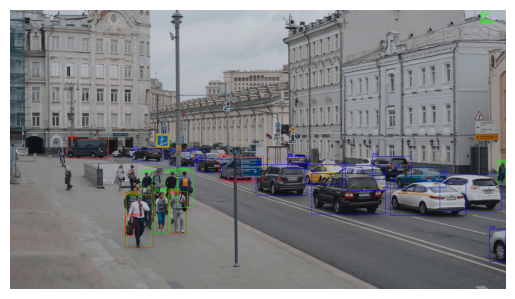


0: 640x640 7 persons, 14 cars, 3 trucks, 830.9ms
Speed: 0.0ms preprocess, 830.9ms inference, 5.2ms postprocess per image at shape (1, 3, 640, 640)
Frame 7: Processado em 0.8683 segundos


KeyboardInterrupt: 

In [ ]:
# Processar vídeo 1
process_video('v1.mp4', 'pv1.mp4', display_frames=True)

In [ ]:
# Processar vídeo 2
process_video('v2.mp4', 'pv2.mp4')


0: 640x640 5 persons, 7 cars, 2 traffic lights, 15.0ms
Speed: 0.0ms preprocess, 15.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)
Frame 899: Processado em 0.0314 segundos


In [ ]:
# Processar vídeo 3
process_video('v3.mp4', 'pv3.mp4')


0: 640x640 3 persons, 8 cars, 1 motorcycle, 3 trucks, 15.7ms
Speed: 0.0ms preprocess, 15.7ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


In [ ]:
# Processar vídeo 4
process_video('v4.mp4', 'pv4.mp4')


0: 640x640 12 cars, 3 traffic lights, 15.5ms
Speed: 0.0ms preprocess, 15.5ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)
Frame 899: Processado em 0.0328 segundos


In [ ]:
# Processar vídeo 5
process_video('v5.mp4', 'pv5.mp4')


0: 640x640 10 persons, 2 cars, 1 bus, 2 traffic lights, 14.9ms
Speed: 0.0ms preprocess, 14.9ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)
Frame 1798: Processado em 0.0398 segundos
